## Extract logits of yes-no tokens for VLM

In [1]:
import copy
import pdb
import yaml
from typing import List, Union, Dict, Tuple
from PIL import Image
import random
from tqdm import tqdm
import json

import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

from data.aokvqa import AOKVQADataset
from utils.okvqa_utils import postprocess_ok_vqa_generation, lemmatize
from utils.openai_utils import openai_caller

import logging

logger = logging.getLogger(__name__)
logging.basicConfig(
        format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S',
        level=logging.INFO)

/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'aokvqa'
split = 'train'
mode = 'direct_answer'

DATASET_TO_DISPLAYNAME = {
    'okvqa': 'OK-VQA',
    'aokvqa': 'A-OKVQA',
    'vqav2': 'VQAv2',
}

DATASET_TO_SIZE = {
    'okvqa': 9009,
    'aokvqa': 17056,
    'vqav2': 15000
}
dataset_displayname = DATASET_TO_DISPLAYNAME[dataset_name]
dataset_size = DATASET_TO_SIZE[dataset_name]

if dataset_name == 'aokvqa':
    if mode == 'direct_answer':
        dataset = AOKVQADataset(split)
    else:
        dataset = AOKVQADataset(split, type='mc')
elif dataset_name == 'okvqa':
    dataset = OKVQADataset(split)



01/20/2024 01:07:58 - INFO - data.aokvqa - Loaded A-OKVQA train dataset with 17056 examples!
01/20/2024 01:07:58 - WARNING - data.aokvqa - Vision/text processors not set!


In [3]:
from models.llm import LLM_CLASS_MAP
from models.vlm import VLM_CLASS_MAP
from models.qgen import QGEN_CLASS_MAP

config_file = '/net/nfs.cirrascale/mosaic/tejass/code/ReCoVERR/configs/recoverr_configs/aokvqa/chatgpt_qgen-flant5xl_llm-instructblipft5xl_vlm.yaml'
device = torch.device("cuda")
# Create agent and environment
config = yaml.safe_load(open(config_file))

# Load VLM
vlm_class = config['vlm']['class_name']
vlm_model_class = VLM_CLASS_MAP[vlm_class]
vlm_config = yaml.safe_load(open(config['vlm']['model_config_path']))
vlm_model = vlm_model_class(vlm_config, device)
vlm_model.set_vqa_inference_params(config['vlm']['vqa_inference_params'])
vlm_model.set_caption_inference_params(config['vlm']['caption_inference_params'])

/home/tejass/.conda/envs/recoverr/lib/python3.10/site-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(
01/20/2024 01:08:22 - INFO - root - freeze vision encoder
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.12it/s]
01/20/2024 01:08:50 - INFO - root - load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/InstructBLIP/instruct_blip_flanxl_trimmed.pth
01/20/2024 01:08:53 - INFO - models.vlm - Loaded BLIP (model=InstructBLIP-FlanT5XL)!
01/20/2024 01:08:53 - INFO - models.vlm - Model size: 4.02B parameters (0.19B trainable), 8.42GB in memory


In [ ]:
yn_outputs_file = f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/uncalibrated_yn_probs/instructblipflant5xl-{dataset_name}_{split}_{mode}.json'
directvqa_rollouts = json.load(open(f'/net/nfs.cirrascale/mosaic/tejass/experiments/recoverr/{dataset_name}_{mode}/train_outputs/instructblipflant5xl_direct_vqa-1rollouts-{dataset_size}examples.json'))


results = []
for i, d in enumerate(tqdm(dataset)):
    #continue
    question = d['question']
    image = d['raw_image']
    qid = d['qid']
    answer, logprobs_dict = vlm_model.ask(image, question)
    r = directvqa_rollouts[str(qid)][0]
    result = {
        "qid": qid,
        "image_id": r['image_id'],
        "question": r['vqa_question'],
        "answer": answer,
        "yn_logits": logprobs_dict['yn_logits'], 
        "yn_prob": logprobs_dict['yn_prob'],
        "lave_score": r['lave_score'], 
    }
    results.append(result)
    #if i == 100:
    #    break

json.dump(results, open(yn_outputs_file, 'w'), indent=2)

## Train Logistic Regression Calibration Model

In [4]:
import numpy as np
yn_outputs_file = f'/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/uncalibrated_yn_probs/instructblipflant5xl-{dataset_name}_{split}_{mode}.json'
results = json.load(open(yn_outputs_file))

X, y = [], []
for r in results:
    #if r['lave_score'] not in [0, 1]:
    #    continue
    X.append(r['yn_logits'])
    y.append(r['lave_score'])
X_test = X[:5000]
y_test  = y[:5000]
X_train = X[5000:]
y_train = y[5000:]

# Remove ambiguous samples
X_train = np.array([x for i, x in enumerate(X_train) if y_train[i] != 0.5])
y_train = np.array([y for i, y in enumerate(y_train) if y_train[i] != 0.5])
X_test = np.array([x for i, x in enumerate(X_test) if y_test[i] != 0.5])
y_test = np.array([y for i, y in enumerate(y_test) if y_test[i] != 0.5])

print("Number of training samples for calibrator model:", X_train.shape)
print("Number of test samples for calibrator model:", X_test.shape)

Number of training samples for calibrator model: (11761, 2)
Number of test samples for calibrator model: (4846, 2)


In [8]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(C=1, solver='lbfgs')
lr_model.fit(X_train, y_train)

LogisticRegression(C=1)

In [9]:
import pickle as pkl

out_fn = f"/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_model/calibrated_{vlm_config['model_shorthand'].replace('_','')}-{dataset_name}_{mode}-calibration_clf.pkl"
pkl.dump(lr_model, open(out_fn, 'wb'))

In [10]:
import pickle as pkl

out_fn = f"/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_model/calibrated_{vlm_config['model_shorthand'].replace('_','')}-{dataset_name}_{mode}-calibration_clf.pkl"
lr_model = pkl.load(open(out_fn, 'rb'))

In [11]:
y_test_calibrated_probs = lr_model.predict_proba(X_test)
predicted_answer_probs = [y[1] for y in y_test_calibrated_probs]
predicted_answer_accs = y_test.tolist()

In [12]:
bin_accs, bin_meanprobs, bin_sizes, bin_stdprobs = [], [], [], []
num_bins = 10
for i in range(num_bins):
    bin_lower = i*1.0/num_bins
    bin_upper = (i+1)*1.0/num_bins
    bin_idxs = [i for i in range(len(predicted_answer_accs)) if predicted_answer_probs[i] >= bin_lower and predicted_answer_probs[i] < bin_upper]
    print(f"Bin {bin_lower:.2f}-{bin_upper:.2f}: {len(bin_idxs)} instances")
    bin_individualaccs = [predicted_answer_accs[i] for i in bin_idxs]
    bin_individualprobs = [predicted_answer_probs[i] for i in bin_idxs]
    print(f"Bin accuracy: {np.mean(bin_individualaccs):.2%}")
    print(f"Mean predicted probability for bin: {np.mean(bin_individualprobs):.2%}")
    bin_accs.append(np.mean(bin_individualaccs))
    bin_meanprobs.append(np.mean(bin_individualprobs))
    bin_sizes.append(len(bin_idxs))
    bin_stdprobs.append(np.std(bin_individualprobs))

Bin 0.00-0.10: 68 instances
Bin accuracy: 16.18%
Mean predicted probability for bin: 5.73%
Bin 0.10-0.20: 172 instances
Bin accuracy: 23.26%
Mean predicted probability for bin: 15.78%
Bin 0.20-0.30: 311 instances
Bin accuracy: 32.15%
Mean predicted probability for bin: 25.22%
Bin 0.30-0.40: 403 instances
Bin accuracy: 31.51%
Mean predicted probability for bin: 35.12%
Bin 0.40-0.50: 506 instances
Bin accuracy: 44.86%
Mean predicted probability for bin: 45.17%
Bin 0.50-0.60: 555 instances
Bin accuracy: 57.48%
Mean predicted probability for bin: 55.07%
Bin 0.60-0.70: 659 instances
Bin accuracy: 60.39%
Mean predicted probability for bin: 65.15%
Bin 0.70-0.80: 848 instances
Bin accuracy: 76.18%
Mean predicted probability for bin: 75.12%
Bin 0.80-0.90: 936 instances
Bin accuracy: 85.04%
Mean predicted probability for bin: 84.98%
Bin 0.90-1.00: 388 instances
Bin accuracy: 94.59%
Mean predicted probability for bin: 92.62%


In [13]:
correct_probs, incorrect_probs = [], []
correct_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 1]
incorrect_idxs = [i for i in range(len(predicted_answer_probs)) if predicted_answer_accs[i] == 0]

correct_probs = [predicted_answer_probs[i] for i in correct_idxs]
incorrect_probs = [predicted_answer_probs[i] for i in incorrect_idxs]
print(f"{len(correct_probs)} correct predictions, {len(incorrect_probs)} incorrect predictions")

3031 correct predictions, 1815 incorrect predictions


In [14]:
unweighted_calibration_error = np.mean(np.abs(np.array(bin_accs) - np.array(bin_meanprobs)))
calibration_error = np.sum((np.abs(np.array(bin_accs) - np.array(bin_meanprobs)))*np.array(bin_sizes))/len(y_test)


from scipy.stats import pearsonr, skew
freqdistr_skew = skew(predicted_answer_probs)
#r = pearsonr(prob_true, prob_pred)
#print(r.statistic)

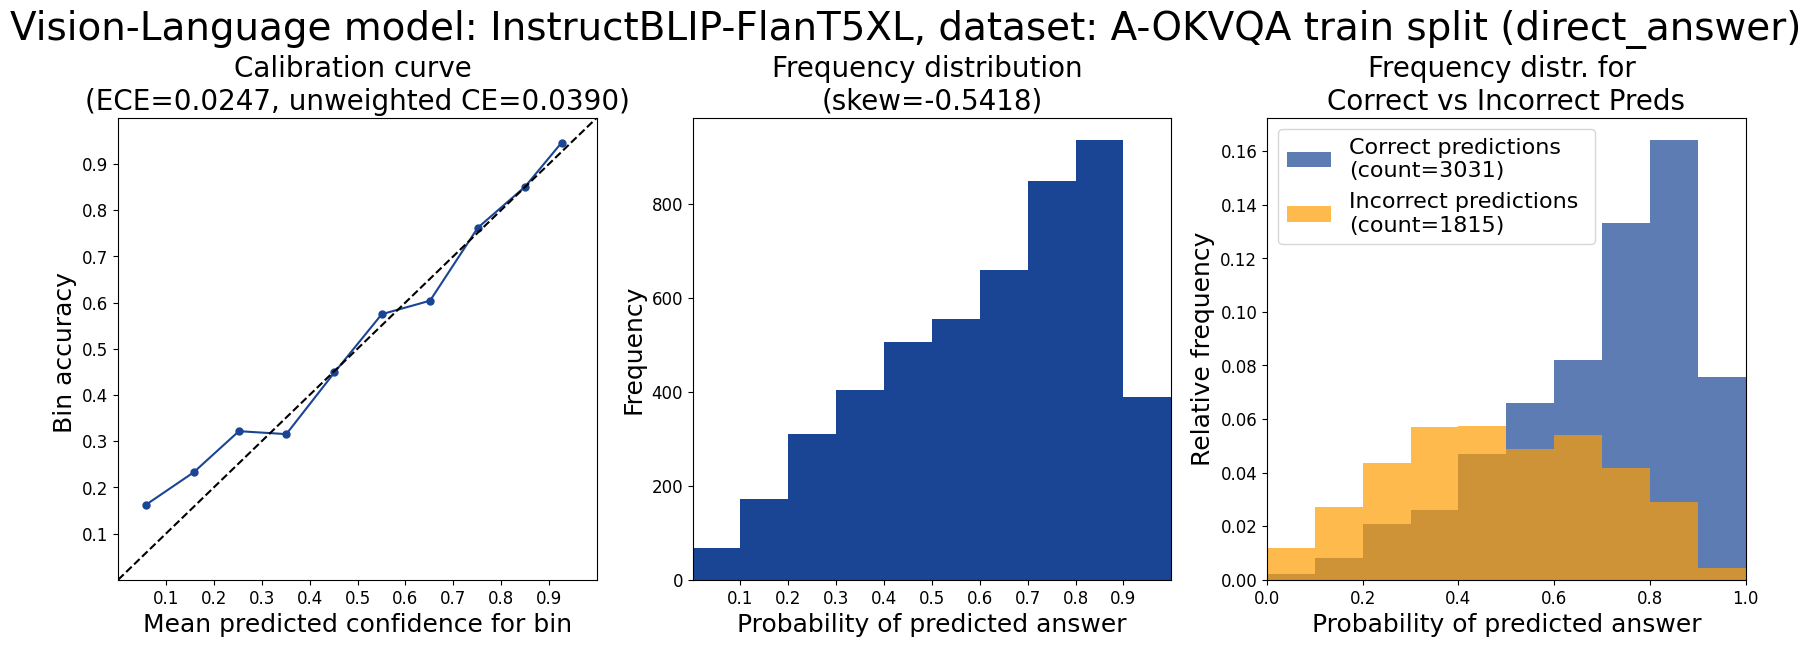

In [15]:
from matplotlib import pyplot as plt
plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Vision-Language model: {vlm_model.display_name}, dataset: {dataset_displayname} train split ({mode})\n\n', fontsize=28, y=1.06)
fig.set_size_inches(21, 6)
ax1.plot(bin_meanprobs, bin_accs, marker='.', markersize=10, color='#1a4595')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve \n(ECE={calibration_error:.4f}, unweighted CE={unweighted_calibration_error:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=18)
ax1.set_ylabel('Bin accuracy ', fontsize=18)

freqhist_bins = np.linspace(0, 1, num_bins+1)
ax2.hist(
    predicted_answer_probs, 
    freqhist_bins, 
    color='#1a4595', 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
)
ax2.set_title(f'Frequency distribution \n(skew={freqdistr_skew:.4f})', fontsize=20)
ax2.set_xlabel('Probability of predicted answer', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])#, fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)


ax3.hist(
    correct_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#1a4595', 
    label='Correct predictions \n(count={})'.format(len(correct_probs)), 
    weights=np.ones_like(correct_probs) / len(y_test))
ax3.hist(
    incorrect_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#ff9d02', 
    label='Incorrect predictions \n(count={})'.format(len(incorrect_probs)), 
    weights=np.ones_like(incorrect_probs) / len(y_test))
ax3.set_title(f'Frequency distr. for \nCorrect vs Incorrect Preds', fontsize=20)
ax3.set_xlabel('Probability of predicted answer', fontsize=18)
ax3.set_ylabel('Relative frequency', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(loc='upper left', fontsize=16)
ax3.set_xlim(0, 1)
plt.show()


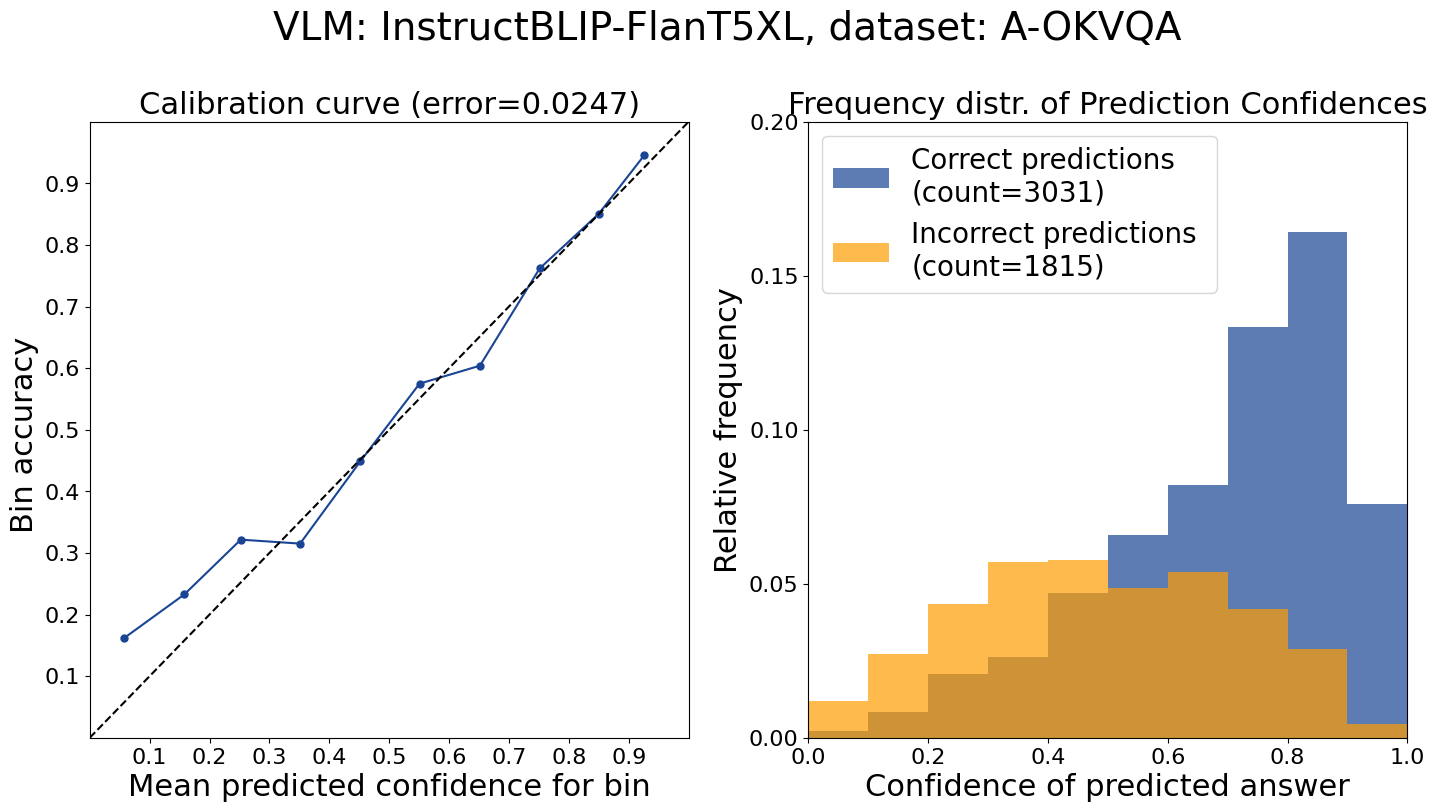

In [16]:
from matplotlib import pyplot as plt
plt.size = (50, 25)
fig, (ax1, ax2) = plt.subplots(1, 2)
#fig.suptitle(f'VLM: {vqa_model_displayname}, dataset: {dataset_displayname} train split ({mode})\n\n', fontsize=28, y=1.02)
fig.suptitle(f'VLM: {vlm_model.display_name}, dataset: {dataset_displayname}\n', fontsize=28, y=1.02)
fig.set_size_inches(17, 8)
ax1.plot(bin_meanprobs, bin_accs, marker='.', markersize=10, color='#1a4595')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve (error={calibration_error:.4f})', fontsize=22)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=22)
ax1.set_ylabel('Bin accuracy ', fontsize=22)

freqhist_bins = np.linspace(0, 1, num_bins+1)
ax2.hist(
    correct_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#1a4595', 
    label='Correct predictions \n(count={})'.format(len(correct_probs)), 
    weights=np.ones_like(correct_probs) / len(y_test))
ax2.hist(
    incorrect_probs, 
    freqhist_bins, 
    alpha=0.7, 
    color='#ff9d02', 
    label='Incorrect predictions \n(count={})'.format(len(incorrect_probs)), 
    weights=np.ones_like(incorrect_probs) / len(y_test))
ax2.set_title(f'Frequency distr. of Prediction Confidences', fontsize=22)
ax2.set_xlabel('Confidence of predicted answer', fontsize=22)
ax2.set_ylabel('Relative frequency', fontsize=22)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.legend(loc='best', fontsize=20)
ax2.set_xlim(0, 1)
ax2.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
plt.show()


In [17]:


correct_preds_confdistribution = []
for i in range(10):
    x = [c for c in correct_probs if c >= i/10 and c < (i+1)/10]
    correct_preds_confdistribution.append(len(x))

incorrect_preds_confdistribution = []
for i in range(10):
    x = [c for c in incorrect_probs if c >= i/10 and c < (i+1)/10]
    incorrect_preds_confdistribution.append(len(x))
    
out_data = {
    'correct_preds_confdistribution': correct_preds_confdistribution,
    'incorrect_preds_confdistribution': incorrect_preds_confdistribution,
    'bin_meanprobs': bin_meanprobs,
    'bin_accs': bin_accs,
    'calibration_error': calibration_error,
}
out_fn = f"/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/calibrated_{vlm_config['model_shorthand'].replace('_','')}-{dataset_name}_{mode}-{len(y_train)}train_{len(y_test)}test_examples.json"
json.dump(out_data, open(out_fn, 'w'), indent=2)

## Analyze Calibrated vs Uncalibrated Confidence Distributions

In [ ]:
import json
import numpy as np
uncalibrated_data = json.load(open('/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/uncalibrated_instructblipflant5xl-aokvqa_direct_answer-5000examples.json'))
calibrated_data = json.load(open('/net/nfs.cirrascale/mosaic/tejass/experiments/vl_calibration/calibration_eval/calibrated_instructblipflant5xl-aokvqa_direct_answer-11761train_4846test_examples.json'))

from matplotlib import pyplot as plt
plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'Vision-Language model: {vlm_model.display_name}, dataset: {dataset_displayname} (calib-eval split)\n\n', fontsize=28, y=1.08)
fig.set_size_inches(18, 5)
ax1.plot(
    calibrated_data['bin_meanprobs'], 
    calibrated_data['bin_accs'], 
    marker='.', markersize=10, 
    label=f"Calibrated VLM \n(error={calibrated_data['calibration_error']:.4f})",
    color='#1a4595')
ax1.plot(
    uncalibrated_data['bin_meanprobs'], 
    uncalibrated_data['bin_accs'], 
    marker='.', markersize=10, 
    label=f"Uncalibrated VLM \n(error={uncalibrated_data['calibration_error']:.4f})",
    color='#ff9d02')
ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Calibration curve', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/10 for i in range(1, 10)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('Mean predicted confidence for bin', fontsize=18)
ax1.set_ylabel('Bin accuracy ', fontsize=18)
ax1.legend(loc='upper left', fontsize=14)

#freqhist_bins = np.linspace(0, 1, num_bins+1)
bar_x = [i/10+0.05 for i in range(10)]
print(sum(calibrated_data['correct_preds_confdistribution']))
print(sum(uncalibrated_data['correct_preds_confdistribution']))
ax2.plot(
    bar_x,
    calibrated_data['correct_preds_confdistribution'],
    color='#1a4595', 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Calibrated model',
)
ax2.fill_between(
    bar_x,
    calibrated_data['correct_preds_confdistribution'],
    color='#1a4595', 
    alpha=0.1,
)
ax2.plot(
    bar_x,
    uncalibrated_data['correct_preds_confdistribution'],
    color='#ff9d02', 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Uncalibrated model',
)
ax2.fill_between(
    bar_x,
    uncalibrated_data['correct_preds_confdistribution'],
    color='#ff9d02', 
    alpha=0.1,
)
ax2.set_title(f'Confidence distribution \nfor correct predictions', fontsize=20)
ax2.set_xlabel('Confidence of predicted answer', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])#, fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0.05, 0.95)
ax2.set_ylim(0, 1000)
ax2.legend(loc='upper left', fontsize=14)

print(sum(calibrated_data['incorrect_preds_confdistribution']))
print(sum(uncalibrated_data['incorrect_preds_confdistribution']))
ax3.plot(
    bar_x,
    calibrated_data['incorrect_preds_confdistribution'],
    color='#1a4595', 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Calibrated model',
)
ax3.fill_between(
    bar_x,
    calibrated_data['incorrect_preds_confdistribution'],
    color='#1a4595', 
    alpha=0.1,
)
ax3.plot(
    bar_x,
    uncalibrated_data['incorrect_preds_confdistribution'],
    color='#ff9d02', 
    #weights=np.ones_like(predicted_answer_probs) / len(y_test)
    label='Uncalibrated model',
)
ax3.fill_between(
    bar_x,
    uncalibrated_data['incorrect_preds_confdistribution'],
    color='#ff9d02', 
    alpha=0.1,
)

ax3.set_title(f'Confidence distribution \nfor incorrect predictions', fontsize=20)
ax3.set_xlabel('Confidence of predicted answer', fontsize=18)
ax3.set_ylabel('Frequency', fontsize=18)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.legend(loc='upper left', fontsize=14)
ax3.set_xlim(0.05, 0.95)
ax3.set_ylim(0, 500)
plt.show()


# Abstention

In [23]:
predicted_answer_probs = [y[1] for y in y_test_calibrated_probs]
predicted_answer_accs = y_test.tolist()

def calculate_abstention_metrics(threshold, error_cost=1):
    num_covered, total_risk, effective_reliability = 0, 0, 0
    qids = list(range(len(predicted_answer_accs)))
    abstained_qids = []
    for idx, (acc, conf) in enumerate(zip(predicted_answer_accs, predicted_answer_probs)):
        selected = True if conf >= threshold else False
        if selected:
            num_covered += 1
            total_risk += 1 - acc #if acc != 1 else 0
            effective_reliability += acc if acc > 0 else -error_cost
        else:
            abstained_qids.append(idx)
    coverage = num_covered/len(qids)
    risk = total_risk/num_covered if num_covered > 0 else 0
    effective_reliability = effective_reliability/len(qids)
    return coverage, risk, effective_reliability, abstained_qids

num_thresholds = 100
penalty = 1
thresholds = [i/num_thresholds for i in range(1, num_thresholds)]
coverages, risks, eff_reliabilities = [], [], []
for t in tqdm(thresholds):
    c, r, e, _ = calculate_abstention_metrics(t, penalty)
    coverages.append(c)
    risks.append(r)
    eff_reliabilities.append(e)
#for t, c, r in zip(thresholds, coverages, risks):
#    print(f"At confidence threshold {t}, coverage={c:.2%}, risk={r:.2%}")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 801.30it/s]


In [24]:
min([thresholds[i] for i in range(num_thresholds-1) if risks[i] < 0.2])

0.65

In [26]:
for i in range(num_thresholds-1):
    print(f"At threshold {thresholds[i]}, coverage={coverages[i]:.4f}, risk={risks[i]:.4f}")

At threshold 0.01, coverage=0.9992, risk=0.3742
At threshold 0.02, coverage=0.9977, risk=0.3735
At threshold 0.03, coverage=0.9963, risk=0.3728
At threshold 0.04, coverage=0.9955, risk=0.3723
At threshold 0.05, coverage=0.9946, risk=0.3718
At threshold 0.06, coverage=0.9938, risk=0.3717
At threshold 0.07, coverage=0.9924, risk=0.3710
At threshold 0.08, coverage=0.9901, risk=0.3697
At threshold 0.09, coverage=0.9884, risk=0.3687
At threshold 0.1, coverage=0.9860, risk=0.3679
At threshold 0.11, coverage=0.9837, risk=0.3671
At threshold 0.12, coverage=0.9810, risk=0.3664
At threshold 0.13, coverage=0.9792, risk=0.3654
At threshold 0.14, coverage=0.9763, risk=0.3648
At threshold 0.15, coverage=0.9721, risk=0.3626
At threshold 0.16, coverage=0.9678, risk=0.3608
At threshold 0.17, coverage=0.9647, risk=0.3596
At threshold 0.18, coverage=0.9608, risk=0.3578
At threshold 0.19, coverage=0.9556, risk=0.3559
At threshold 0.2, coverage=0.9505, risk=0.3530
At threshold 0.21, coverage=0.9449, risk=0

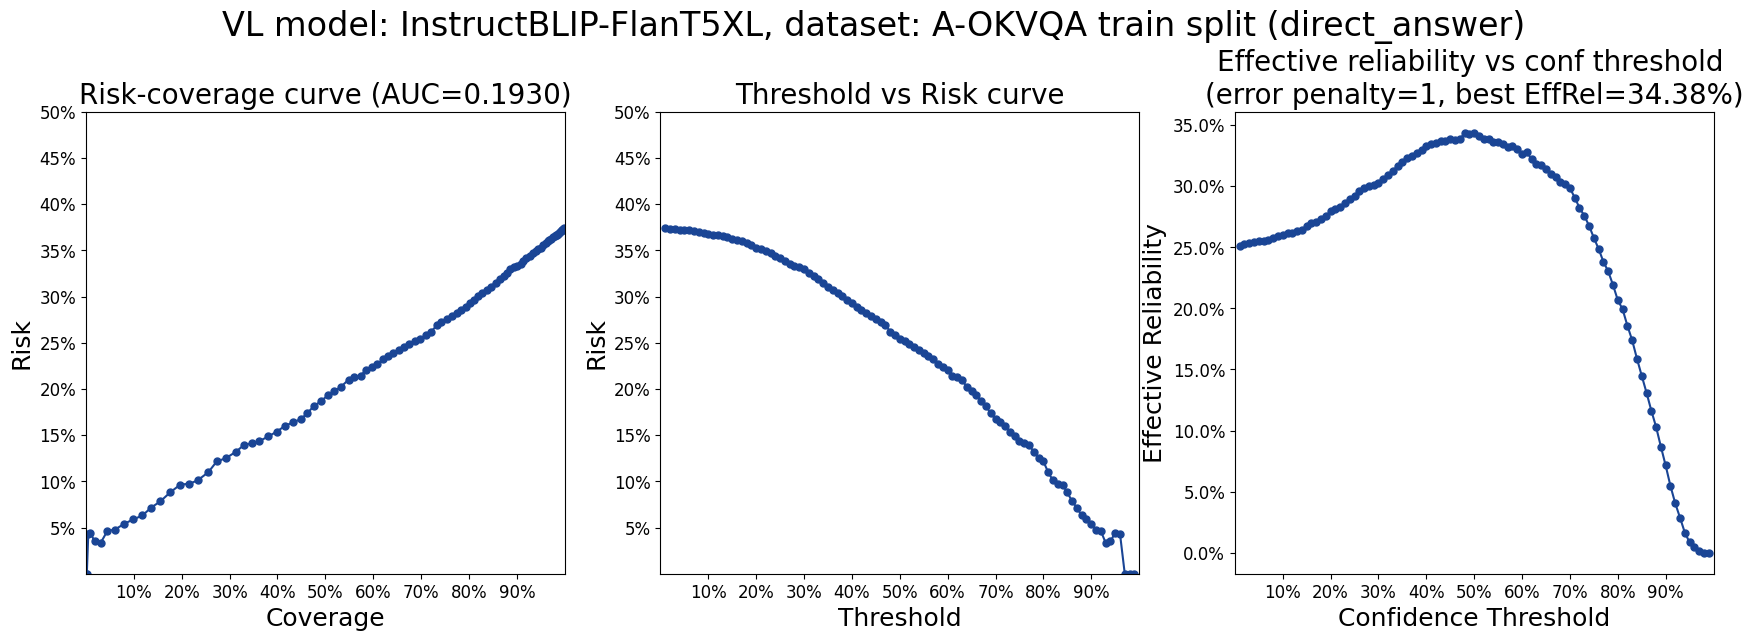

In [29]:
from sklearn import metrics
auc = metrics.auc(coverages, risks)

from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

plt.size = (50, 25)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle(f'VL model: {vlm_model.display_name}, dataset: {dataset_displayname} train split ({mode})\n\n\n\n', fontsize=24, y=1.05)
fig.set_size_inches(21, 6)
ax1.plot(coverages, risks, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax1.set_title(f'Risk-coverage curve (AUC={auc:.4f})', fontsize=20)
ax1.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax1.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 0.5)
ax1.set_xlabel('Coverage', fontsize=18)
ax1.set_ylabel('Risk', fontsize=18)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax1.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax2.plot(thresholds, risks, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax2.set_title(f'Threshold vs Risk curve', fontsize=20)
ax2.set_xticks(ticks=[i/10 for i in range(1, 10)])
ax2.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 0.5)
ax2.set_xlabel('Threshold', fontsize=18)
ax2.set_ylabel('Risk', fontsize=18)
ax2.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

ax3.plot(thresholds, eff_reliabilities, marker='.', markersize=10, color='#1a4595')
#ax1.plot([0,1], [0,1], linestyle='--', color='k')
#ax1.errorbar(bin_meanprobs, bin_accs, xerr=bin_stdprobs, ecolor='k', barsabove=False, color='')
ax3.set_title(f'Effective reliability vs conf threshold \n(error penalty={penalty}, best EffRel={max(eff_reliabilities):.2%})', fontsize=20)
ax3.set_xticks(ticks=[i/10 for i in range(1, 10)])
#ax.set_yticks(ticks=[i/20 for i in range(1, 20)])
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlim(0, 1)
#ax.set_ylim(0, 0.5)
ax3.set_xlabel('Confidence Threshold', fontsize=18)
ax3.set_ylabel('Effective Reliability', fontsize=18)
ax3.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax3.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()